In [1]:
import numpy as np
import math
import sympy as sym
from sympy.functions.elementary.trigonometric import atan2
from scipy.integrate import ode
from scipy.stats import chisquare
from sympy.utilities.lambdify import lambdify
from IPython.core.debugger import Tracer
import Kep_2_Cart
import Cart_2_Kep
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.


alt = 400e3 #meters

Notes:
   
- Experiment takes plan in the summer on June 24th
- MSIS density values generated using lst calculated from the lon directly. I believe this needs to be this way b/c will populate for all local sidereal times as though greenwich is midnight, but this shell is not actually dependent on location on Earth, it is only dependent on its angle/location WRT the sun, will convert this grid to sun fixed coordinate system post generation
- 

In [2]:

#generate spatial latitude/longitude grid
latitudes = np.arange(-90, 91, 5)
latitudes = np.radians(latitudes)
num_lat = len(latitudes)

longitudes = np.arange(0, 361, 5)
longitudes = np.radians(longitudes)
num_lon = len(longitudes)

print(num_lat, num_lon)

37 73


(73, 37) (73, 37) (37, 73)


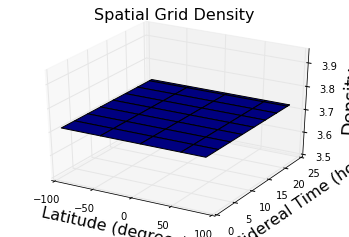

In [3]:

def gen_one_member(alt):
    
    num_lat = len(latitudes)
    num_lon = len(longitudes)
    density_grid = np.zeros((num_lat, num_lon))
    
    if alt < 400e3:
        rho_0 = 9.518e-12 #kg/m^3
        h_0 = 350e3 #meters
        H = 53.298e3 #meters
    else:
        rho_0 = 3.725e-12 #kg/m^3
        h_0 = 400e3 #meters
        H = 58.515e3 #meters
        

    density = rho_0 * math.exp(-(alt - h_0)/H)
    
    density_grid = np.tile(density, (num_lat, num_lon))
            
            
    return density_grid


alt = 400e3
#generate ensemble
density_grid = gen_one_member(alt)


mydict = {'density_grid': density_grid}
output = open('Data Files/nominal_density_grid.pkl', 'wb')
pickle.dump(mydict, output)
output.close()



#X, Y = np.meshgrid(np.degrees(latitudes), np.degrees(longitudes))

lsts = longitudes/(2*math.pi) * 24

X, Y = np.meshgrid(np.degrees(latitudes), lsts)

#print(density_grid[20,:])

print(np.shape(X), np.shape(Y), np.shape(density_grid))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, density_grid.T)
ax.set_xlabel('Latitude (degrees)', fontsize=16)
ax.set_ylabel('Local Sidereal Time (hours)', fontsize=16)
ax.set_zlabel('Density', fontsize=18)
ax.set_title('Spatial Grid Density', fontsize=16)
plt.show()

In [3]:

def gen_one_ensemble(latitudes, longitudes):
    
    num_lat = len(latitudes)
    num_lon = len(longitudes)
    density_grid = np.zeros((num_lat, num_lon))

    #loop through spatial latitude/longitude grid

    for ii in range(num_lat):

        lat = latitudes[ii]

        for jj in range(num_lon):

            lon = longitudes[jj]

            day_of_year = 175 #June 24th
            
            #check if lon is negative or wrapped around after 2 pi
            if lon > 2*math.pi:
                lon = lon - 2*math.pi
            elif lon < 0:
                lon = lon + 2*math.pi
                
            lst = lon/(2*math.pi) * 24 #fraction of 360 degrees converted to hours
            #print(lst)

            lon = 0
                
            Output = nrlmsise_output()
            Input = nrlmsise_input()
            flags = nrlmsise_flags()
            aph = ap_array()

            for i in range(7):
                aph.a[i]=100
            flags.switches[0] = 1
            for i in range(1, 24):
                flags.switches[i]=1

            Input.doy = day_of_year
            Input.year = 0 #/* without effect */
            Input.sec = 0
            Input.alt = alt/1000 #convert to km
            Input.g_lat = math.degrees(lat)
            Input.g_long = math.degrees(lon)
            Input.lst = lst #I believe this needs to be lst b/c will populate for all local sidereal times
            #as though greenwich is midnight, but this shell is not actually dependent on location on Earth,
            #it is only dependent on its angle/location WRT the sun, will convert this grid to sun fixed 
            #coordinate system post generation
            Input.f107A = 80 #I believe this is a "nominal" value
            Input.f107 = 80
            Input.ap = 4 

            gtd7d(Input, flags, Output)

            density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
            density = density
            #print(rho)

            density_grid[ii, jj] = density
            
            
    return density_grid

[  4.90482544e-13   4.91795061e-13   4.91158501e-13   4.87937088e-13
   4.81834411e-13   4.72910293e-13   4.61555101e-13   4.48429622e-13
   4.34384343e-13   4.20373249e-13   4.07374825e-13   3.96328512e-13
   3.88089876e-13   3.83403311e-13   3.82887623e-13   3.87027960e-13
   3.96167482e-13   4.10494546e-13   4.30025557e-13   4.54588951e-13
   4.83819632e-13   5.17173374e-13   5.53966139e-13   5.93435525e-13
   6.34814005e-13   6.77399818e-13   7.20612709e-13   7.64027037e-13
   8.07381346e-13   8.50568748e-13   8.93614855e-13   9.36649375e-13
   9.79874806e-13   1.02353201e-12   1.06785947e-12   1.11304166e-12
   1.15914310e-12   1.20602868e-12   1.25327690e-12   1.30010011e-12
   1.34529231e-12   1.38722810e-12   1.42393342e-12   1.45323724e-12
   1.47299512e-12   1.48135354e-12   1.47700632e-12   1.45938888e-12
   1.42876671e-12   1.38619947e-12   1.33339295e-12   1.27247722e-12
   1.20576219e-12   1.13551901e-12   1.06382071e-12   9.92455343e-13
   9.22905500e-13   8.56375176e-13

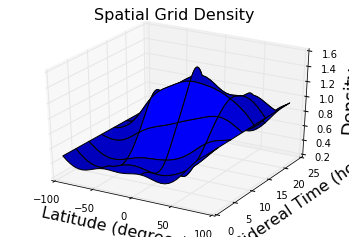

In [35]:
#generate ensemble
density_grid = gen_one_ensemble(latitudes, longitudes)

#X, Y = np.meshgrid(np.degrees(latitudes), np.degrees(longitudes))

lsts = longitudes/(2*math.pi) * 24

X, Y = np.meshgrid(np.degrees(latitudes), lsts)

print(density_grid[20,:])

print(np.shape(X), np.shape(Y), np.shape(density_grid))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, density_grid.T)
ax.set_xlabel('Latitude (degrees)', fontsize=16)
ax.set_ylabel('Local Sidereal Time (hours)', fontsize=16)
ax.set_zlabel('Density', fontsize=18)
ax.set_title('Spatial Grid Density', fontsize=16)
plt.show()

In [5]:

def gen_one_ensemble(latitudes, longitudes, day_of_year, f107_nom, f107, ap, sec, alt):

    num_lat = len(latitudes)
    num_lon = len(longitudes)
    density_grid = np.zeros((num_lat, num_lon))
    
    #loop through spatial latitude/longitude grid

    for ii in range(num_lat):

        lat = latitudes[ii]

        for jj in range(num_lon):

            lon = longitudes[jj]
            
            #check if lon is negative or wrapped around after 2 pi
            if lon > 2*math.pi:
                lon = lon - 2*math.pi
            elif lon < 0:
                lon = lon + 2*math.pi

            lst = lon/(2*math.pi) * 24 #fraction of 360 degrees converted to hours

            lon = 0

            Output = nrlmsise_output()
            Input = nrlmsise_input()
            flags = nrlmsise_flags()
            aph = ap_array()

            for i in range(7):
                aph.a[i]=100
            flags.switches[0] = 1
            for i in range(1, 24):
                flags.switches[i]=1

            Input.doy = day_of_year
            Input.year = 0 #/* without effect */
            Input.sec = sec
            Input.alt = alt #km
            Input.g_lat = math.degrees(lat)
            Input.g_long = math.degrees(lon)
            Input.lst = lst #I believe this needs to be lst b/c will populate for all local sidereal times
            #as though greenwich is midnight, but this shell is not actually dependent on location on Earth,
            #it is only dependent on its angle/location WRT the sun, will convert this grid to sun fixed 
            #coordinate system post generation
            Input.f107A = f107_nom #/* 81 day average of F10.7 flux (centered on doy) */
            Input.f107 = f107 #/* daily F10.7 flux for previous day */
            Input.ap = ap 

            gtd7d(Input, flags, Output)

            density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
            density = density 
            #print(rho)

            density_grid[ii, jj] = density
            
            
    return density_grid

In [51]:

def gen_mult_ensemble(latitudes, longitudes, day_of_year_offset_vec, f107_offset_vec, ap_offset_vec):

    DoY_len = len(day_of_year_offset_vec)
    f107_len = len(f107_offset_vec)
    ap_len = len(ap_offset_vec)
    
    print(DoY_len, f107_len, ap_len)
    
    ensemble_of_density_grids = np.array([])
    
    #set nominal values
    day_of_year_nom = 175 #June 24th
    f107_nom = 180
    ap_nom = 10
    
    #set parameters for this ensemble
    for ii in range(DoY_len):
        day_of_year = day_of_year_nom + day_of_year_offset_vec[ii]
        
        for kk in range(f107_len):
            f107 = f107_nom + f107_offset_vec[kk]

            for ll in range(ap_len):
                ap = ap_nom + ap_offset_vec[ll]

                density_grid = gen_one_ensemble(latitudes, longitudes, day_of_year, f107_nom, f107, ap)

                ensemble_of_density_grids = np.append(ensemble_of_density_grids, density_grid)

                print(ii, kk, ll)
            
            
    return ensemble_of_density_grids


def gen_mult_ensemble_gauss(latitudes, longitudes, day_of_year_offset_vec, f107_offset_vec, \
                            ap_offset_vec, sec_offset_vec, alt_offset_vec, num_of_members):

    DoY_len = len(day_of_year_offset_vec)
    f107_len = len(f107_offset_vec)
    ap_len = len(ap_offset_vec)
    sec_len = len(sec_offset_vec)
    alt_len = len(alt_offset_vec)
    
    
    ensemble_of_density_grids = np.array([])
    
    #set nominal values
    day_of_year_nom = 175 #June 24th
    f107_nom = 180
    ap_nom = 10
    sec_nom = 0
    alt_nom = 400 #km
    
    #set parameters for this ensemble
    for ii in range(num_of_members):
        
        index = DoY_len*np.random.random()
        day_of_year = day_of_year_nom + day_of_year_offset_vec[int(index)]
        
        index = f107_len*np.random.random()
        f107 = f107_nom + f107_offset_vec[int(index)]

        index = ap_len*np.random.random()
        ap = ap_nom + ap_offset_vec[int(index)]
        
        index = sec_len*np.random.random()
        sec = sec_nom + sec_offset_vec[int(index)]
        
        index = alt_len*np.random.random()
        alt = alt_nom + alt_offset_vec[int(index)]

        density_grid = gen_one_ensemble(latitudes, longitudes, day_of_year, f107_nom, f107, ap, sec, alt)

        ensemble_of_density_grids = np.append(ensemble_of_density_grids, density_grid)

        print(ii)
            
            
    return ensemble_of_density_grids





In [60]:
#define all of the offsets for the different ensmebles

day_of_year_offset_vec = np.arange(-6, 7, 2) #whole day offsets
f107_offset_vec = np.array([-50, -40, -30, -20, -10, 0, 25, 40, 60])
ap_offset_vec = np.array([-7, -6, -5, -4, -3, -1, 0, 10, 20, 65])
sec_offset_vec = np.zeros((1))  #np.linspace(0, 86400, 10) 
alt_offset_vec = np.arange(-5, 0, 1)  

tot_combos = 450

ensemble_of_density_grids = \
    gen_mult_ensemble_gauss(latitudes, longitudes, day_of_year_offset_vec, f107_offset_vec, ap_offset_vec, \
                            sec_offset_vec, alt_offset_vec, tot_combos)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


KeyboardInterrupt: 

In [54]:

np.mean(ensemble_of_density_grids) *1e9


0.0047665642324392432

In [53]:
#reshape ensemble of spatial grids (i.e., ensembles)
num_DoY = len(day_of_year_offset_vec)
num_f107 = len(f107_offset_vec)
num_ap = len(ap_offset_vec)

tot_combos = 450

ensemble_of_density_grids = ensemble_of_density_grids.reshape(tot_combos, num_lat, num_lon)
print(np.shape(ensemble_of_density_grids))

mydict = {'ensemble_of_density_grids': ensemble_of_density_grids, 'latitudes': latitudes, 'longitudes': longitudes}
output = open('Data Files/ensemble_density_grids.pkl', 'wb')
pickle.dump(mydict, output)
output.close()

(450, 37, 73)


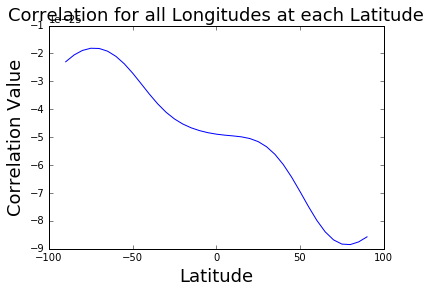

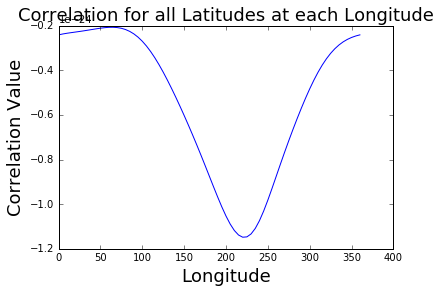

In [27]:

#Correlation Matrix Analysis


# read python dict containing measurements
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensemble_of_density_grids = mydict2['ensemble_of_density_grids'] 


#grid of mean density values over Ensemble
ensemble_mean = np.mean(ensemble_of_density_grids, axis=0)

lon_cor_array = np.zeros(num_lat)
lat_cor_array = np.zeros(num_lon)



for lat_index in range(num_lat):
    
    lons = ensemble_mean[lat_index, :]
    var = np.var(lons)
    mean = np.mean(lons)
    lon_cor_array[lat_index] = var - mean**2
    
    
for lon_index in range(num_lon):
       
    lats = ensemble_mean[:, lon_index]
    var = np.var(lats)
    mean = np.mean(lats)
    lat_cor_array[lon_index] = var - mean**2
        


fig = plt.figure()
plt.plot(np.degrees(latitudes), lon_cor_array)
plt.ylabel('Correlation Value', fontsize=18)
plt.xlabel('Latitude', fontsize=18)
plt.title('Correlation for all Longitudes at each Latitude', fontsize=18)
plt.show()

fig = plt.figure()
plt.plot(np.degrees(longitudes), lat_cor_array)
plt.ylabel('Correlation Value', fontsize=18)
plt.xlabel('Longitude', fontsize=18)
plt.title('Correlation for all Latitudes at each Longitude', fontsize=18)
plt.show()

In [25]:

#Chi-Squared & Mahalanobis Analysis



day_of_year_offset_vec = np.arange(-6, 7, 2) #whole day offsets
f107_offset_vec = np.arange(-6, 7, 2)
ap_offset_vec = np.arange(-.4, .6, .2)

member_num = 450
loop_num = 1
num_samples = member_num # * states, but only doing one density param right now (so, *1)

chisqrd_array = np.zeros(loop_num-1)
mahalanobis_dist_array = np.zeros(loop_num-1)

lats = np.array([latitudes[18]])
lons = np.array([longitudes[17]])

p_val = -1

for ii in range(loop_num):
    
    ensemble_of_density_grids = \
        gen_mult_ensemble_gauss(lats, lons, day_of_year_offset_vec, f107_offset_vec, ap_offset_vec, member_num)

    print(ii)
    

    """
    #chi-squared test
    mean = np.mean(ensemble_of_density_grids)
    diff = (ensemble_of_density_grids - mean).reshape(member_num, 1)
    std = np.std(diff)
    chisqrd = np.dot(diff.T, diff)/std**2
    chisqrd_array[ii-1] = chisqrd
    """
    
    std_md = np.std(ensemble_of_density_grids) #std for mahalanobis distance
    
       
    if ii != 0:
        
        #Mahalanobis Distance 
        #M12 = (x1-x2)'*inv(xCov1+xCov2)*(x1-x2)
        diff = np.absolute(ensemble_of_density_grids - ensemble_of_density_grids_old).reshape(member_num, 1)
        mahalanobis_dist = np.dot(diff.T, diff) / (std_md**2 + std_md_old**2) 
        mahalanobis_dist_array[ii-1] = mahalanobis_dist
        
    
    std_md_old = std_md
        
    ensemble_of_density_grids_old = ensemble_of_density_grids

    
    """
    fig = plt.figure()
    plt.hist(ensemble_of_density_grids[:])
    plt.ylabel('Frequency', fontsize=18)
    plt.xlabel('Density', fontsize=18)
    plt.title('Density Histogram', fontsize=18)
    plt.show()
    """
    

    
fig = plt.figure()
plt.hist(ensemble_of_density_grids[:])
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Density', fontsize=18)
plt.title('Density Histogram', fontsize=18)
plt.show()

print(np.mean(ensemble_of_density_grids[:]))

fig = plt.figure()
plt.plot(chisqrd_array)
plt.ylabel('Chi-Squared', fontsize=18)
plt.xlabel('Ensemble Number', fontsize=18)
plt.title('Chi-Squared between Ensembles', fontsize=18)
plt.show()


fig = plt.figure()
plt.plot(mahalanobis_dist_array)
plt.ylabel('Mahalanobis Distance', fontsize=18)
plt.xlabel('Ensemble Number', fontsize=18)
plt.title('Mahalanobis Dist.', fontsize=18)
plt.show()

> <ipython-input-23-e96ff521015c>(20)gen_one_ensemble()
     19             Tracer() ()
---> 20             if lon > 2*math.pi:
     21                 lon = lon - 2*math.pi

ipdb> n
> <ipython-input-23-e96ff521015c>(22)gen_one_ensemble()
     21                 lon = lon - 2*math.pi
---> 22             elif lon < 0:
     23                 lon = lon + 2*math.pi

ipdb> n
> <ipython-input-23-e96ff521015c>(25)gen_one_ensemble()
     24 
---> 25             lst = lon/(2*math.pi) * 24 #fraction of 360 degrees converted to hours
     26             print(lst)

ipdb> n
> <ipython-input-23-e96ff521015c>(26)gen_one_ensemble()
     25             lst = lon/(2*math.pi) * 24 #fraction of 360 degrees converted to hours
---> 26             print(lst)
     27             lon = 0

ipdb> lst
5.666666666666667
ipdb> q
Exiting Debugger.


In [189]:
#Simple Chi-Squared Example


x = np.random.randn(50)*1e-13 
x_mean = np.mean(x)
print(x_mean)

x_diff = x - x_mean

x_std = np.std(x)
print(np.std(x_diff/x_std)) #good: should be one


chi_sqrd = np.dot(x_diff.T, x_diff)/x_std**2
print(chi_sqrd)

-1.18094180823e-15
1.0
50.0


In [154]:
#Simple Mahalanobis Distance Example
#Note: if both distributions are normal then MD = chi-sqrd

x1 = np.random.randn(50)
x2 = np.random.randn(50)

x_diff = np.absolute(x1 - x2)

x1_std = np.std(x1)
x2_std = np.std(x2)
print(np.std(x_diff/(x1_std + x2_std))) #good: should be one

md = np.dot(x_diff.T, x_diff)/(x1_std + x2_std)
print(md)

0.45800065532
59.2698217702


In [3]:
density_grid = np.zeros((10, 10))
    
#loop through spatial latitude/longitude grid

counter = 0

for ii in range(10):

    for jj in range(10):

        density_grid[ii,jj] = counter
        
        counter = counter + 1
        
density_grid

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
       [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.],
       [ 20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.],
       [ 30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.],
       [ 40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.],
       [ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.],
       [ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.],
       [ 70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.],
       [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.],
       [ 90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.]])

In [14]:
density_grid.reshape(100).reshape(10, 10)

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
       [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.],
       [ 20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.],
       [ 30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.],
       [ 40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.],
       [ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.],
       [ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.],
       [ 70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.],
       [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.],
       [ 90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.]])

In [7]:

day_of_year_nom = 175 #June 24th
f107_nom = 180
ap_nom = 10
sec_offset_vec = np.zeros((1))  #np.linspace(0, 86400, 10) 
alt_offset_vec = np.arange(-5, 0, 1)  

    
density_grid = gen_one_ensemble(latitudes, longitudes, day_of_year_nom, f107_nom, f107_nom, ap_nom, 0, 400)

print(np.mean(density_grid)*1e9)
lat_grid_ticks = 24
lst_grid_ticks = 38

nom_grid = density_grid.reshape(num_lat, num_lon)
print(nom_grid[lat_grid_ticks, lst_grid_ticks])
print('mean:', np.mean(nom_grid))
print('max:', np.max(nom_grid))
print('min:', np.min(nom_grid))

0.00476509057514
7.75465043957e-12
mean: 4.76509057514e-12
max: 8.13654280426e-12
min: 2.70198315652e-12


In [11]:


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids_moreRealistic.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensemble = mydict2['ensemble_of_density_grids'] 


ensemble_mean = np.mean(ensemble.reshape(450, num_lat, num_lon), axis=0)
print(np.shape(ensemble_mean))

diff = ensemble_mean - nom_grid
ind = np.where(diff*1e9 > .004)[0]
print(ensemble_mean[lat_grid_ticks, lst_grid_ticks])

(37, 73)
7.6209724554e-12


In [55]:
np.shape(ensemble_of_density_grids)
np.mean(ensemble_of_density_grids.reshape(450, num_lat, num_lon)[:,lat_grid_ticks, lst_grid_ticks])

7.6993531775511903e-12

In [7]:
density_grids = np.append(density_grids, density_grid)

In [13]:
density_grids_reshaped1 = density_grids.reshape(2, 10, 10)

density_grids_reshaped2 = density_grids_reshaped1.reshape(2, 100).T
print(density_grids_reshaped2)
print(density_grids_reshaped2.T.reshape(2, 10, 10))

[[  0.   0.]
 [  1.   1.]
 [  2.   2.]
 [  3.   3.]
 [  4.   4.]
 [  5.   5.]
 [  6.   6.]
 [  7.   7.]
 [  8.   8.]
 [  9.   9.]
 [ 10.  10.]
 [ 11.  11.]
 [ 12.  12.]
 [ 13.  13.]
 [ 14.  14.]
 [ 15.  15.]
 [ 16.  16.]
 [ 17.  17.]
 [ 18.  18.]
 [ 19.  19.]
 [ 20.  20.]
 [ 21.  21.]
 [ 22.  22.]
 [ 23.  23.]
 [ 24.  24.]
 [ 25.  25.]
 [ 26.  26.]
 [ 27.  27.]
 [ 28.  28.]
 [ 29.  29.]
 [ 30.  30.]
 [ 31.  31.]
 [ 32.  32.]
 [ 33.  33.]
 [ 34.  34.]
 [ 35.  35.]
 [ 36.  36.]
 [ 37.  37.]
 [ 38.  38.]
 [ 39.  39.]
 [ 40.  40.]
 [ 41.  41.]
 [ 42.  42.]
 [ 43.  43.]
 [ 44.  44.]
 [ 45.  45.]
 [ 46.  46.]
 [ 47.  47.]
 [ 48.  48.]
 [ 49.  49.]
 [ 50.  50.]
 [ 51.  51.]
 [ 52.  52.]
 [ 53.  53.]
 [ 54.  54.]
 [ 55.  55.]
 [ 56.  56.]
 [ 57.  57.]
 [ 58.  58.]
 [ 59.  59.]
 [ 60.  60.]
 [ 61.  61.]
 [ 62.  62.]
 [ 63.  63.]
 [ 64.  64.]
 [ 65.  65.]
 [ 66.  66.]
 [ 67.  67.]
 [ 68.  68.]
 [ 69.  69.]
 [ 70.  70.]
 [ 71.  71.]
 [ 72.  72.]
 [ 73.  73.]
 [ 74.  74.]
 [ 75.  75.]
 [ 76.  76.]

AttributeError: 'NoneType' object has no attribute 'T'